In [1]:
# https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/latest/hand_landmarker.task
import mediapipe as mp
import numpy as np
from mediapipe.framework.formats import landmark_pb2
import cv2

In [2]:
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

model_path = 'hand_landmarker.task'

# options for landmarker in image mode:
options = mp.tasks.vision.HandLandmarkerOptions(
    base_options=mp.tasks.BaseOptions(model_asset_path=model_path),
    running_mode=mp.tasks.vision.RunningMode.IMAGE,
    min_hand_detection_confidence = 0.2,
    min_hand_presence_confidence = 0.2,
    min_tracking_confidence = 0.2,
    # num_hands=2
)

def close(landmarker):
  landmarker.close()

In [3]:
# Is this still neccesary with just images?
def get_result(result: mp.tasks.vision.HandLandmarkerResult, output_image: mp.Image, timestamp_ms: int):
    return result
    # print(f'hand landmarker result: {result}') 



In [4]:
def draw_landmarks_on_image(rgb_image, detection_result: mp.tasks.vision.HandLandmarkerResult):
    """Courtesy of https://github.com/googlesamples/mediapipe/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb"""
    global first
    try:
        if detection_result.hand_landmarks == []:
            return rgb_image
        else:
            hand_landmarks_list = detection_result.hand_landmarks
            annotated_image = np.copy(rgb_image)
            
            # Loop through the detected hands to visualize.
            for idx in range(len(hand_landmarks_list)):
                print(hand_landmarks_list[idx])
                hand_landmarks = hand_landmarks_list[idx]
                # Draw the hand landmarks.
                hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
                hand_landmarks_proto.landmark.extend([
                    landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks])
                mp.solutions.drawing_utils.draw_landmarks(
                    annotated_image,
                    hand_landmarks_proto,
                    mp.solutions.hands.HAND_CONNECTIONS,
                    mp.solutions.drawing_styles.get_default_hand_landmarks_style(),
                    mp.solutions.drawing_styles.get_default_hand_connections_style())
                
            return annotated_image
    except Exception as e:
        print(e, 'exception')
        return rgb_image

In [5]:
def detect(image, clazz, landmarker):
    return (landmarker.detect(image=image), clazz)

In [ ]:
# load the landmarker
#landmarker = mp.tasks.vision.HandLandmarker.create_from_options(options)

# load image
#image = mp.Image.create_from_file('./data/American Sign Language Letters.v1-v1.tensorflow/train/M18_jpg.rf.129826d37d00c7e46376752d8649edaa.jpg')

# detect result to draw detected keypoints on frame
#detection_result = detect(image, 'A', landmarker)
#image_with_landmarks = draw_landmarks_on_image(image.numpy_view(), detection_result[0])

# show frame with keypoints drawn
#cv2.imshow('Image', image_with_landmarks)

# stop!
#cv2.waitKey(0)
        
#close(landmarker)
#cv2.destroyAllWindows()

I0000 00:00:1760438209.004331 3308331 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1760438209.010665 3308449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1760438209.016991 3308452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1760438209.042921 3308452 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


[NormalizedLandmark(x=0.4512444734573364, y=0.6170030236244202, z=-9.343098383851611e-08, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.48954522609710693, y=0.5841641426086426, z=-0.02537645399570465, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4955238997936249, y=0.5283651947975159, z=-0.044034961611032486, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.44175049662590027, y=0.500369668006897, z=-0.06216815486550331, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3925633132457733, y=0.48377835750579834, z=-0.07727379351854324, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4785412847995758, y=0.46633273363113403, z=-0.026574909687042236, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4938644468784332, y=0.424955278635025, z=-0.06438133120536804, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5115581154823303, y=0.4621637463569641, z=-0.0878673866391182, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5188916325569153, y=0.50019

In [6]:
def get_keypoints(landmarker, base_path, file_name, clazz):
    image = mp.Image.create_from_file(base_path + file_name)
    return detect(image, clazz, landmarker)

In [17]:
def create_coord_list(detected_landmarks):
  coord_list = []
  for i in detected_landmarks:
    coord_list.append([i.x, i.y, i.z])
  return coord_list
    
def orthonormal_basis_from_triangle(p1, p2, p3):
    """Return orthonormal triad (e1,e2,e3): e1 along (p2-p1), e2 in the plane, e3 = normal."""
    u = p2 - p1
    v = p3 - p1
    n = np.cross(u, v)
    if np.linalg.norm(n) < 1e-12:
        raise ValueError("Anchor points are collinear; cannot define a plane.")
    e1 = u / np.linalg.norm(u)
    v_perp = v - np.dot(v, e1) * e1
    e2 = v_perp / np.linalg.norm(v_perp)
    e3 = np.cross(e1, e2)  # already unit
    return e1, e2, e3

def solve_affine2d(src_xy, dst_xy):
    """Solve 2D affine mapping (x,y)->(X,Y) from 3 point pairs. Returns 2x2 M and 2-dim t."""
    A, b = [], []
    for (x, y), (X, Y) in zip(src_xy, dst_xy):
        A.append([x, y, 1, 0, 0, 0])
        A.append([0, 0, 0, x, y, 1])
        b += [X, Y]
    A = np.asarray(A, float)
    b = np.asarray(b, float)
    m11, m12, tx, m21, m22, ty = np.linalg.solve(A, b)
    M = np.array([[m11, m12],
                  [m21, m22]], float)
    t = np.array([tx, ty], float)
    return M, t

def normalize_landmarks(points, anchor_idx=(0,5,17), lambda_normal=1.0):
    """
    Build a 3D affine transform (A,t) so that:
      P[i1] -> (0,0,0), P[i2] -> (0,1,0), P[i3] -> (1,1,0),
    and the plane normal maps to the Z axis with scale lambda_normal.
    Returns transformed points (N,3) and (A,t).
    """
    P = np.asarray(points, float)
    i1, i2, i3 = anchor_idx
    p1, p2, p3 = P[i1], P[i2], P[i3]

    # Local orthonormal basis B = [e1 e2 e3]
    e1, e2, e3 = orthonormal_basis_from_triangle(p1, p2, p3)
    B = np.column_stack([e1, e2, e3])          # world <- local
    BT = B.T                                    # local <- world

    # Local coordinates of anchors (q = BT * (p - p1))
    q1 = BT @ (p1 - p1)                         # ~ (0,0,0)
    q2 = BT @ (p2 - p1)                         # (x2, y2, 0)
    q3 = BT @ (p3 - p1)                         # (x3, y3, 0)

    src_xy = np.vstack([q1[:2], q2[:2], q3[:2]])
    dst_xy = np.array([[0.,0.],[0.,1.],[1.,1.]], float)

    # Exact 2D affine that hits the three targets in XY
    M2, t2 = solve_affine2d(src_xy, dst_xy)

    # Compose full 3x3 local linear map: XY via M2, Z via lambda_normal
    L_local = np.array([[M2[0,0], M2[0,1], 0.0],
                        [M2[1,0], M2[1,1], 0.0],
                        [0.0,      0.0,    lambda_normal]], float)

    # Because q1 = (0,0,0) maps to (0,0,0), t2 should be ~0; keep it for completeness
    t_local = np.array([t2[0], t2[1], 0.0], float)

    # Convert to a single world-space affine: P' = A @ P + t
    # q = BT @ (P - p1);  q' = L_local @ q + t_local;  P' = q'  (targets are in world axes)
    A = L_local @ BT
    t = -L_local @ (BT @ p1) + t_local

    # Apply to all points
    normalized_points = (A @ P.T).T + t

    return normalized_points

In [30]:
def store_result(result, clazz, normalize = False):
    d = {}
    if normalize:
        coords = create_coord_list(result.hand_landmarks[0])
        norm_coords = normalize_landmarks(coords)
        for k in range(len(coords)):
            d[str(k)+'_x'] = norm_coords[k][0]
            d[str(k)+'_y'] = norm_coords[k][1]
            d[str(k)+'_z'] = norm_coords[k][2]
    
    else:
        for k,v in enumerate(result.hand_landmarks[0]):
            d[str(k)+'_x'] = v.x
            d[str(k)+'_y'] = v.y
            d[str(k)+'_z'] = v.z
        
    d['clazz'] = clazz
    # print(d)
    return d
    
    # store result values in dict and add to list

In [31]:
# convert list of dicts to pd.df
def get_data_frame(result_list):
    return pd.DataFrame(result_list)

In [32]:
#!pip install pandas==2.1.4 moet numpy <2 gebruiken voor mediapipe!
import pandas as pd

# create the landmarker
landmarker = mp.tasks.vision.HandLandmarker.create_from_options(options)

train_data = pd.read_csv('./data/American Sign Language Letters.v1-v1.tensorflow/train/_annotations.csv')
train_data.head()

train_data[:1]
counter = 0
result_list = []

# loop through images in csv and get results
for i in range(len(train_data)):
    values = train_data[i:i+1][['filename','class']].values[0]
    file_name, clazz = values[0], values[1]
    result = get_keypoints(landmarker, './data/American Sign Language Letters.v1-v1.tensorflow/train/', file_name, clazz)
    if len(result[0].hand_landmarks) > 0:
        result_list.append(store_result(result[0], clazz, True))


I0000 00:00:1760439817.036206 3309367 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1760439817.071510 3329502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1760439817.082874 3329502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [33]:
# Load results into DataFrame
df = get_data_frame(result_list)
df.head()

,0_x,0_y,0_z,1_x,1_y,1_z,2_x,2_y,2_z,3_x,...,18_x,18_y,18_z,19_x,19_y,19_z,20_x,20_y,20_z,clazz
0,0.000000e+00,-1.665335e-16,0.0,0.051151,0.418408,-0.116948,0.313171,0.875858,-0.120896,0.753522,...,1.378992,1.422093,-0.037938,1.391327,1.457696,-0.117657,1.287880,1.442945,-0.179997,U
1,0.000000e+00,4.440892e-16,0.0,-0.500715,0.146556,0.124153,-0.302899,0.587350,0.146748,0.139316,...,1.098523,1.203304,0.140975,0.925014,0.970262,0.197557,0.793556,0.783978,0.206621,K
2,2.220446e-16,-2.220446e-16,0.0,-0.107941,0.357834,-0.172900,0.027115,0.715688,-0.221606,0.429796,...,1.255662,1.418025,-0.058884,1.146438,1.463558,-0.139139,1.009603,1.451439,-0.197115,W
3,0.000000e+00,9.714451e-17,0.0,-0.135337,0.331609,0.027450,-0.246668,0.688461,0.058371,-0.279964,...,1.096815,1.280826,0.084684,1.021232,1.312749,0.125159,0.935288,1.333942,0.139606,J
4,-4.440892e-16,-4.440892e-16,0.0,-0.243715,0.159669,0.093121,-0.370448,0.520738,0.105590,-0.249700,...,1.245611,1.282340,0.034350,1.095569,0.985857,0.062559,0.893832,0.714608,0.071866,M


<class 'pandas.core.series.Series'>
RangeIndex: 1298 entries, 0 to 1297
Series name: clazz
Non-Null Count  Dtype 
--------------  ----- 
1298 non-null   object
dtypes: object(1)
memory usage: 10.3+ KB
None
['U' 'K' 'W' ... 'A' 'W' 'S']
(1298, 2)
[ 1  1 14 ... 10 14  9]


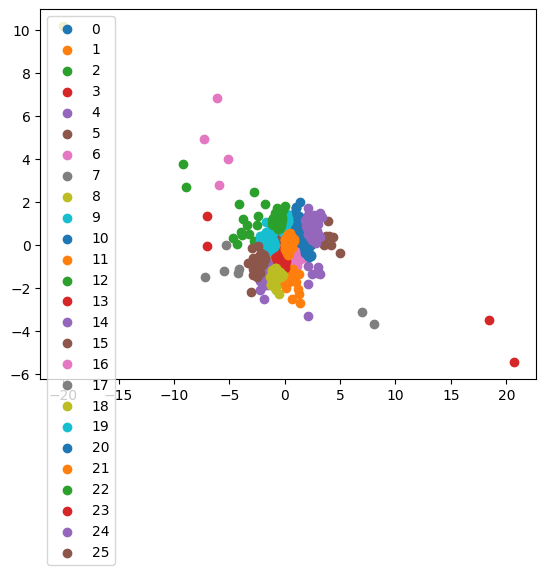

In [34]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# split into data and targets
df_training_x = df[['0_x','0_y','0_z','1_x','1_y','1_z','2_x','2_y','2_z'
                    ,'3_x','3_y','3_z','4_x','4_y','4_z','5_x','5_y','5_z'
                    ,'6_x','6_y','6_z','7_x','7_y','7_z','8_x','8_y','8_z'
                    ,'9_x','9_y','9_z','10_x','10_y','10_z','11_x','11_y','11_z'
                    ,'12_x','12_y','12_z','13_x','13_y','13_z','14_x','14_y','14_z'
                    ,'15_x','15_y','15_z','16_x','16_y','16_z','17_x','17_y','17_z'
                    ,'18_x','18_y','18_z','19_x','19_y','19_z','20_x','20_y','20_z'
]]

df_training_y = df['clazz']

# print information for DataFrame
print(df_training_y.info())
print(df_training_y.values)

# reduce dimensions for plotting and plot 26 clusters
pca = PCA(2)
x = pca.fit_transform(df_training_x.values)
print(x.shape)
kmeans = KMeans(n_clusters=26, random_state=42).fit(x) #for 2 Clusters
print(kmeans.labels_)

#Getting unique labels
unique_labels = np.unique(kmeans.labels_)

# plotting results: 
for i in unique_labels:
    plt.scatter(x[kmeans.labels_ == i , 0] , x[kmeans.labels_ == i , 1] , label = i)
plt.legend()
plt.show()

# TODO: assign letters to labels....


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

logreg = LogisticRegression(max_iter=500, tol=1e-12).fit(df_training_x.values, df_training_y.values)

print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=df_training_y, y_pred=logreg.predict(X=df_training_x.values))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=df_training_y, y_pred=logreg.predict(X=df_training_x.values))))
print(classification_report(y_true=df_training_y, y_pred=logreg.predict(X=df_training_x.values)))

print()


for i in range(len(df_training_x)):
    print(df_training_y.iloc[i], logreg.predict([df_training_x.iloc[i]]))


model fit in 500 iterations
accuracy: 0.8475
f1: 0.8456
              precision    recall  f1-score   support

           A       0.71      0.91      0.79        64
           B       0.85      1.00      0.92        35
           C       0.79      0.82      0.81        33
           D       0.84      0.82      0.83        50
           E       0.87      0.94      0.91        51
           F       1.00      0.98      0.99        53
           G       0.88      0.94      0.91        49
           H       0.89      0.92      0.90        36
           I       0.83      0.92      0.87        71
           J       0.84      0.58      0.68        71
           K       0.98      0.91      0.94        45
           L       0.91      0.91      0.91        64
           M       0.93      0.84      0.88        45
           N       0.86      0.83      0.85        53
           O       0.67      0.83      0.74        47
           P       0.77      0.85      0.80        39
           Q       0.62  

/opt/anaconda3/envs/mp312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
import session_info
session_info.show()

In [ ]:
# split into data and targets
df_training_x = df[['0_x','0_y','0_z','1_x','1_y','1_z','2_x','2_y','2_z'
                    ,'3_x','3_y','3_z','4_x','4_y','4_z','5_x','5_y','5_z'
                    ,'6_x','6_y','6_z','7_x','7_y','7_z','8_x','8_y','8_z'
                    ,'9_x','9_y','9_z','10_x','10_y','10_z','11_x','11_y','11_z'
                    ,'12_x','12_y','12_z','13_x','13_y','13_z','14_x','14_y','14_z'
                    ,'15_x','15_y','15_z','16_x','16_y','16_z','17_x','17_y','17_z'
                    ,'18_x','18_y','18_z','19_x','19_y','19_z','20_x','20_y','20_z'
]]

df_training_y = df['clazz']

normalize_landmarks()

# print information for DataFrame
print(df_training_y.info())
print(df_training_y.values)

# reduce dimensions for plotting and plot 26 clusters
pca = PCA(2)
x = pca.fit_transform(df_training_x.values)
print(x.shape)
kmeans = KMeans(n_clusters=26, random_state=42).fit(x) #for 2 Clusters
print(kmeans.labels_)

#Getting unique labels
unique_labels = np.unique(kmeans.labels_)

# plotting results: 
for i in unique_labels:
    plt.scatter(x[kmeans.labels_ == i , 0] , x[kmeans.labels_ == i , 1] , label = i)
plt.legend()
plt.show()

# TODO: assign letters to labels....